In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from raw_processing import ColumnTransformerPandas
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, make_scorer

### Generate dataset

In [5]:
label_scheme = 'labels_2'

pd.options.display.max_columns = None

dataset = pd.read_csv(f'../processed_data/dataset_allfeatures_inc_labels.csv', low_memory=False)
dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
print(dataset[label_scheme].value_counts())
dataset.head()

dwarf_nova_SU_UMa    630
dwarf_nova_Z_Cam     174
nova_like            144
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
int_polar             49
AMCVn                 46
nova                  46
Name: labels_2, dtype: int64


,oid_ztf,oid_aavso,type_aavso,Eclipsing,CV_Types,CV_subtypes,CV_subsubtypes,eclipse_clear,manual_label,Clarity,labels_1,labels_2,labels_3,labels_4,Amplitude_g,AndersonDarling_g,Autocor_length_g,Beyond1Std_g,CAR_mean_g,CAR_sigma_g,CAR_tau_g,Con_g,Eta_e_g,FluxPercentileRatioMid20_g,FluxPercentileRatioMid35_g,FluxPercentileRatioMid50_g,FluxPercentileRatioMid65_g,FluxPercentileRatioMid80_g,Freq1_harmonics_amplitude_0_g,Freq1_harmonics_amplitude_1_g,Freq1_harmonics_amplitude_2_g,Freq1_harmonics_amplitude_3_g,Freq1_harmonics_rel_phase_1_g,Freq1_harmonics_rel_phase_2_g,Freq1_harmonics_rel_phase_3_g,Freq2_harmonics_amplitude_0_g,Freq2_harmonics_amplitude_1_g,Freq2_harmonics_amplitude_2_g,Freq2_harmonics_amplitude_3_g,Freq2_harmonics_rel_phase_1_g,Freq2_harmonics_rel_phase_2_g,Freq2_harmonics_rel_phase_3_g,Freq3_harmonics_amplitude_0_g,Freq3_harmonics_amplitude_1_g,Freq3_harmonics_amplitude_2_g,Freq3_harmonics_amplitude_3_g,Freq3_harmonics_rel_phase_1_g,Freq3_harmonics_rel_phase_2_g,Freq3_harmonics_rel_phase_3_g,Gskew_g,LinearTrend_g,MaxSlope_g,Mean_g,Meanvariance_g,MedianAbsDev_g,MedianBRP_g,PairSlopeTrend_g,PercentAmplitude_g,PercentDifferenceFluxPercentile_g,PeriodLS_g,Period_fit_g,Psi_CS_g,Psi_eta_g,Q31_g,Rcs_g,Skew_g,SlottedA_length_g,SmallKurtosis_g,Std_g,StetsonK_g,StetsonK_AC_g,StructureFunction_index_21_g,StructureFunction_index_31_g,StructureFunction_index_32_g,Amplitude_r,AndersonDarling_r,Autocor_length_r,Beyond1Std_r,CAR_mean_r,CAR_sigma_r,CAR_tau_r,Con_r,Eta_e_r,FluxPercentileRatioMid20_r,FluxPercentileRatioMid35_r,FluxPercentileRatioMid50_r,FluxPercentileRatioMid65_r,FluxPercentileRatioMid80_r,Freq1_harmonics_amplitude_0_r,Freq1_harmonics_amplitude_1_r,Freq1_harmonics_amplitude_2_r,Freq1_harmonics_amplitude_3_r,Freq1_harmonics_rel_phase_1_r,Freq1_harmonics_rel_phase_2_r,Freq1_harmonics_rel_phase_3_r,Freq2_harmonics_amplitude_0_r,Freq2_harmonics_amplitude_1_r,Freq2_harmonics_amplitude_2_r,Freq2_harmonics_amplitude_3_r,Freq2_harmonics_rel_phase_1_r,Freq2_harmonics_rel_phase_2_r,Freq2_harmonics_rel_phase_3_r,Freq3_harmonics_amplitude_0_r,Freq3_harmonics_amplitude_1_r,Freq3_harmonics_amplitude_2_r,Freq3_harmonics_amplitude_3_r,Freq3_harmonics_rel_phase_1_r,Freq3_harmonics_rel_phase_2_r,Freq3_harmonics_rel_phase_3_r,Gskew_r,LinearTrend_r,MaxSlope_r,Mean_r,Meanvariance_r,MedianAbsDev_r,MedianBRP_r,PairSlopeTrend_r,PercentAmplitude_r,PercentDifferenceFluxPercentile_r,PeriodLS_r,Period_fit_r,Psi_CS_r,Psi_eta_r,Q31_r,Rcs_r,Skew_r,SlottedA_length_r,SmallKurtosis_r,Std_r,StetsonK_r,StetsonK_AC_r,StructureFunction_index_21_r,StructureFunction_index_31_r,StructureFunction_index_32_r,Q31_color,StetsonJ,StetsonL,median_g,min_mag_g,max_mag_g,n_obs_g,dif_min_mean_g,dif_min_median_g,dif_max_mean_g,dif_max_median_g,dif_max_min_g,temporal_baseline_g,kurtosis_g,pwr_max_g,freq_pwr_max_g,FalseAlarm_prob_g,pwr_maxovermean_g,npeaks_pt5to1_g,rrate_pt5to1_g,drate_pt5to1_g,amp_pt5to1_g,npeaks_1to2_g,rrate_1to2_g,drate_1to2_g,amp_1to2_g,npeaks_2to5_g,rrate_2to5_g,drate_2to5_g,amp_2to5_g,npeaks_above5_g,rrate_above5_g,drate_above5_g,amp_above5_g,rollstd_ratio_t20s10_g,stdstilllev_t20s10_g,rollstd_ratio_t10s5_g,stdstilllev_t10s5g,pnts_leq_rollMedWin20-1mag_g,pnts_leq_rollMedWin20-2mag_g,pnts_leq_rollMedWin20-5mag_g,pnts_geq_rollMedWin20+1mag_g,pnts_geq_rollMedWin20+2mag_g,pnts_geq_rollMedWin20+3mag_g,pnts_leq_median-1mag_g,pnts_leq_median-2mag_g,pnts_leq_median-5mag_g,pnts_geq_median+1mag_g,pnts_geq_median+2mag_g,pnts_geq_median+3mag_g,median_r,min_mag_r,max_mag_r,n_obs_r,dif_min_mean_r,dif_min_median_r,dif_max_mean_r,dif_max_median_r,dif_max_min_r,temporal_baseline_r,kurtosis_r,pwr_max_r,freq_pwr_max_r,FalseAlarm_prob_r,pwr_maxovermean_r,npeaks_pt5to1_r,rrate_pt5to1_r,drate_pt5to1_r,amp_pt5to1_r,npeaks_1to2_r,rrate_1to2_r,drate_1to2_r,amp_1to2_r,npeaks_2to5_r,rrate_2to5_r,drate_2to5_r,amp_2to5_r,npeaks_above5_r,rrate_above5_r,drate_above5_r,amp_above5_r,rollstd_ratio_t20s10_r,stdstilllev_t20s10_r,rollstd_ratio_t10s5_r,stdstilllev_t10s5r,pnts_leq_roll

In [6]:
# Features and labels.
X = dataset.iloc[:,14:]
X_cols = X.columns.tolist()
y_names = dataset[label_scheme]
enc = LabelEncoder().fit(y_names)
y = enc.transform(y_names)

print(X.shape)

# Train, test, split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

(1439, 256)


### Define classifiers

In [7]:
rf = RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1, random_state=1)
# knn = 1
# gnb = GaussianNB()


### Pipeline

In [5]:
# Imputation and normalisation functions.
# Using subclassed ColumnTransformerPandas to return a Dataframe with columns instead of just an array (what is usually returned)
impute_simple = ColumnTransformerPandas([
    ('imputer', SimpleImputer(strategy='mean'), X_cols)],
    remainder='passthrough')

impute_KNN = ColumnTransformerPandas([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance'), X_cols)],
    remainder='passthrough')

normalise = ColumnTransformerPandas([
    ('normalise', StandardScaler(), X_cols)], 
    remainder='passthrough')

# Under and oversampling strategies.
size = 390
class_dist_us = {enc.transform(['dwarf_nova_SU_UMa'])[0]:size}

class_dist_os = {enc.transform(['dwarf_nova_SU_UMa'])[0]:size,
                 enc.transform(['dwarf_nova_Z_Cam'])[0]:size,
                 enc.transform(['dwarf_nova_U_Gem'])[0]:size,
                 enc.transform(['nova_like_VY_Scl'])[0]:size,
                 enc.transform(['polar'])[0]:size,
                 enc.transform(['nova_like'])[0]:size,
                 enc.transform(['nova'])[0]:size,
                 enc.transform(['int_polar'])[0]:size,
                 enc.transform(['AMCVn'])[0]:size
                }

undersample = RandomUnderSampler(sampling_strategy=class_dist_us, random_state=1)
oversample = ADASYN(sampling_strategy=class_dist_os, n_neighbors=5,random_state=1)

# Classifier to use.
classifier = rf
classifierNm= 'RF'

# Generate a pipeline to perform the column transformations sequentially.
validation_pipe = Pipeline([
    ('preimpnorm', normalise),
    ('impute', impute_KNN),
    ('us', undersample),
    ('os', oversample),
    ('normalise', None),
    ('clf', classifier)
])


# Lets display the pipeline to see the processes.
# with display='diagram', simply use display() to see the diagram
set_config(display='diagram')
display(validation_pipe)
# if desired, set display back to the default
# set_config(display='text')

# Get parameters of everything in the pipeline, including ColumnTransformer and classifier functions.
# Get all keys beginning with 'clf__' to get all the classifier parameters.
validation_pipe.get_params().keys()
[k for k in validation_pipe.get_params().keys() if k.startswith('clf__')]



Pipeline(steps=[('preimpnorm',
                 ColumnTransformerPandas(remainder='passthrough',
                                         transformers=[('normalise',
                                                        StandardScaler(),
                                                        ['Amplitude_g',
                                                         'AndersonDarling_g',
                                                         'Autocor_length_g',
                                                         'Beyond1Std_g',
                                                         'CAR_mean_g',
                                                         'CAR_sigma_g',
                                                         'CAR_tau_g', 'Con_g',
                                                         'Eta_e_g',
                                                         'FluxPercentileRatioMid20_g',
                                                         'FluxPercentileRatioMid35_g',
                                                         'FluxPercentileRatioMid50_g',
                                                         'FluxPercentile...
                                                         'Freq3_harmonics_amplitude_0_g',
                                                         'Freq3_harmonics_amplitude_1_g', ...])])),
                ('us',
                 RandomUnderSampler(random_state=1,
                                    sampling_strategy={1: 390})),
                ('os',
                 ADASYN(random_state=1,
                        sampling_strategy={0: 390, 1: 390, 2: 390, 3: 390,
                                           4: 390, 5: 390, 6: 390, 7: 390,
                                           8: 390})),
                ('normalise', None),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_jobs=-1, random_state=1))])

['clf__bootstrap',
 'clf__ccp_alpha',
 'clf__class_weight',
 'clf__criterion',
 'clf__max_depth',
 'clf__max_features',
 'clf__max_leaf_nodes',
 'clf__max_samples',
 'clf__min_impurity_decrease',
 'clf__min_samples_leaf',
 'clf__min_samples_split',
 'clf__min_weight_fraction_leaf',
 'clf__n_estimators',
 'clf__n_jobs',
 'clf__oob_score',
 'clf__random_state',
 'clf__verbose',
 'clf__warm_start']

### Validation curves

[0.56, 0.58, 0.6, 0.62, 0.64]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END .............................clf__max_features=0.56; total time=  20.9s
[CV] END .............................clf__max_features=0.58; total time=  21.7s
[CV] END ..............................clf__max_features=0.6; total time=  21.9s
[CV] END .............................clf__max_features=0.62; total time=  22.0s
[CV] END .............................clf__max_features=0.64; total time=  21.9s
[CV] END .............................clf__max_features=0.56; total time=  23.6s
[CV] END .............................clf__max_features=0.58; total time=  23.6s
[CV] END ..............................clf__max_features=0.6; total time=  23.8s
[CV] END .............................clf__max_features=0.62; total time=  21.5s
[CV] END .............................clf__max_features=0.56; total time=  23.7s
[CV] END .............................clf__max_features=0.58; total time=  24.2s
[CV] END .............................clf__max_features=0.64; total time=  25.7s
[CV] END ...................

[Parallel(n_jobs=4)]: Done  25 out of  50 | elapsed:  3.1min remaining:  3.1min


[CV] END .............................clf__max_features=0.56; total time=  35.8s
[CV] END .............................clf__max_features=0.58; total time=  36.7s
[CV] END ..............................clf__max_features=0.6; total time=  36.9s
[CV] END .............................clf__max_features=0.62; total time=  34.6s
[CV] END .............................clf__max_features=0.56; total time=  33.6s
[CV] END .............................clf__max_features=0.58; total time=  34.6s
[CV] END .............................clf__max_features=0.64; total time=  37.2s
[CV] END ..............................clf__max_features=0.6; total time=  32.9s
[CV] END .............................clf__max_features=0.56; total time=  35.2s
[CV] END .............................clf__max_features=0.62; total time=  37.1s
[CV] END .............................clf__max_features=0.64; total time=  37.0s
[CV] END .............................clf__max_features=0.58; total time=  33.1s
[CV] END ...................

[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  6.8min finished


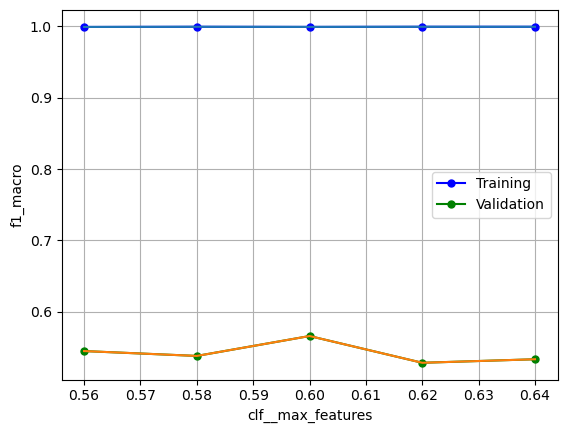

In [72]:
param_name = 'clf__max_features'
param_range = [0.56, 0.58,0.6,0.62, 0.64]#list(range())#np.linspace(0.05,1,20)
 #list(range(0,1,0.05))
print(param_range)
n_jobs = 4 # max number of cores to use, -1 uses all cores - that would be 8 for me.
verbose = 2

train_scoreNum, test_scoreNum = validation_curve(
                                estimator=validation_pipe,
                                X=X_train, 
                                y=y_train, 
                                param_name = param_name, 
                                param_range = param_range,
                                cv = 10,
                                scoring='f1_macro',
                                verbose=verbose,
                                n_jobs=n_jobs)

train_mean = np.mean(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)
print(f'Training set mean: {train_mean}\nValidation set mean: {test_mean}')

# Plot the model scores (accuracy) against the paramater range
plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation')
plt.legend()
plt.plot(param_range, train_mean)
plt.plot(param_range, test_mean)
plt.xlabel(param_name)
plt.ylabel('f1_macro')
plt.grid()
plt.show()

### Hyperparameter tuning with CV grid/randomised search

In [6]:
rf_paramgrid = {
    'clf__n_estimators': [200],
    'clf__max_depth': [None, 9, 10, 11],
    'clf__min_samples_split': [2, 10, 18],
    'clf__min_samples_leaf': [1],
    'clf__max_features': [0.2, 0.6],
    'clf__bootstrap': [True],
    'clf__class_weight': ['balanced_subsample', None]
}



In [74]:
# Initiaze the hyperparameters for each dictionary
params = [rf_paramgrid]
# Select grid search cv folds
n_folds = 10
n_iter = 50
# Scorers
scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision_score': make_scorer(precision_score, average='macro', zero_division=True), # weighted precision
    'recall_score': make_scorer(recall_score, average='macro'), # weighted recall
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=True) #'f1_weighted': 'f1_weighted'
}
# Compile GridSearchCV settings.
refit = 'f1_macro'
grid = RandomizedSearchCV(validation_pipe, params, scoring=scoring, refit=refit, cv=n_folds, n_iter=n_iter, verbose=verbose, n_jobs=n_jobs)


# Fit different models on training data
grid.fit(X_train, y_train)

# Place results in a dataframe.
cv_results = pd.DataFrame(grid.cv_results_)

/Users/aridmist/opt/anaconda3/envs/phd/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] END clf__bootstrap=True, clf__class_weight=balanced_subsample, clf__max_depth=None, clf__max_features=0.2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=  15.7s
[CV] END clf__bootstrap=True, clf__class_weight=balanced_subsample, clf__max_depth=None, clf__max_features=0.2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=  15.7s
[CV] END clf__bootstrap=True, clf__class_weight=balanced_subsample, clf__max_depth=None, clf__max_features=0.2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=  15.7s
[CV] END clf__bootstrap=True, clf__class_weight=balanced_subsample, clf__max_depth=None, clf__max_features=0.2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=  15.7s
[CV] END clf__bootstrap=True, clf__class_weight=balanced_subsample, clf__max_depth=None, clf__max_features=0.2, clf__

### Use best parameters to generate a model

In [75]:
cv_results.to_csv(f'../results/{classifierNm}_cv_results.csv')

In [110]:
# Obtain the best estimator parameters from the grid search
best_params = grid.best_params_
# Remove the clf__ prefix from the keys
best_params = {k.replace('clf__', ''):v for k,v in best_params.items()}
print(best_params)
test_params = {'bootstrap': True,
    'class_weight': 'balanced_subsample',
    'max_depth': 10,
    'max_features': 0.6,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200}

random_state = 1

clf_best_params = RandomForestClassifier(**test_params, random_state=random_state)
# Under and oversampling strategies.
size2= 300
class_dist_us2 = {enc.transform(['dwarf_nova_SU_UMa'])[0]:size2}

class_dist_os2 = {enc.transform(['dwarf_nova_SU_UMa'])[0]:size2,
                 enc.transform(['dwarf_nova_Z_Cam'])[0]:size2,
                 enc.transform(['dwarf_nova_U_Gem'])[0]:size2,
                 enc.transform(['nova_like_VY_Scl'])[0]:size2,
                 enc.transform(['polar'])[0]:size2,
                 enc.transform(['nova_like'])[0]:size2,
                 enc.transform(['nova'])[0]:size2,
                 enc.transform(['int_polar'])[0]:size2,
                 enc.transform(['AMCVn'])[0]:size2
                }

undersample2 = RandomUnderSampler(sampling_strategy=class_dist_us2, random_state=random_state)
oversample2 = ADASYN(sampling_strategy=class_dist_os2, n_neighbors=5,random_state=random_state)

# Use those to train a new model using the whole trianing set.
# Generate a pipeline to perform the column transformations sequentially.
pipe2 = Pipeline([
    ('preimpnorm', normalise),
    ('impute', impute_KNN),
    ('us', undersample2),
    ('os', oversample2),
    ('normalise', None),
    ('clf', clf_best_params)
])

best_model = pipe2.fit(X_train, y_train)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.2, 'max_depth': 10, 'class_weight': None, 'bootstrap': True}


In [83]:
def plot_roc(y_train, y_test, y_prob, label_encoder, path):

    from sklearn.preprocessing import LabelBinarizer
    from sklearn.metrics import roc_curve, auc, RocCurveDisplay
    from itertools import cycle
    import matplotlib.pyplot as plt
    import numpy as np


    # One hot encode the class labels
    # y_onehot_test.shape (n_samples, n_classes)
    # we use a LabelBinarizer to binarize the target by one-hot-encoding in a OvR fashion. 
    # This means that the target of shape (n_samples,) is mapped to a target of shape (n_samples, n_classes)
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test) 


    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()


    # Compute micro-average ROC curve and ROC area
    # ROC curve using micro-averaged OvR
    # Micro-averaging aggregates the contributions from all the classes (using np.ravel) to compute the average metrics as follows:
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    n_classes = label_encoder.classes_.shape[0]

    # Store the fpr, tpr and roc_auc for each class vs the remaining classes.
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area
    # Threshold values of probability
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)
    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
    # Average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    # Construct plots
    fig, ax = plt.subplots(figsize=(8, 8))



    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["red", "orange", "grey", "lightgreen", "green", "cyan", "blue", "indigo", "violet", "darkgrey"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_prob[:, class_id],
            name=f"{label_encoder.inverse_transform(np.unique(y_train))[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) curves \nOne-vs-Rest multiclass")
    plt.legend()
    plt.savefig(path, format='pdf', bbox_inches='tight')
    plt.show()

# Plot feature importances
def plot_feature_importance(importance,names,model_type, path, top_n=20):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.iloc[0:top_n,:]

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.savefig(path, format='pdf', bbox_inches='tight')


                   precision  recall  f1-score  support
AMCVn                   0.41    0.64      0.50       14
dwarf_nova_SU_UMa       0.94    0.76      0.84      189
dwarf_nova_U_Gem        0.49    0.63      0.55       35
dwarf_nova_Z_Cam        0.62    0.65      0.64       52
int_polar               0.25    0.07      0.11       15
nova                    0.64    0.64      0.64       14
nova_like               0.63    0.72      0.67       43
nova_like_VY_Scl        0.65    0.67      0.66       36
polar                   0.52    0.79      0.63       34
accuracy                0.70    0.70      0.70        0
macro avg               0.57    0.62      0.58      432
weighted avg            0.72    0.70      0.70      432


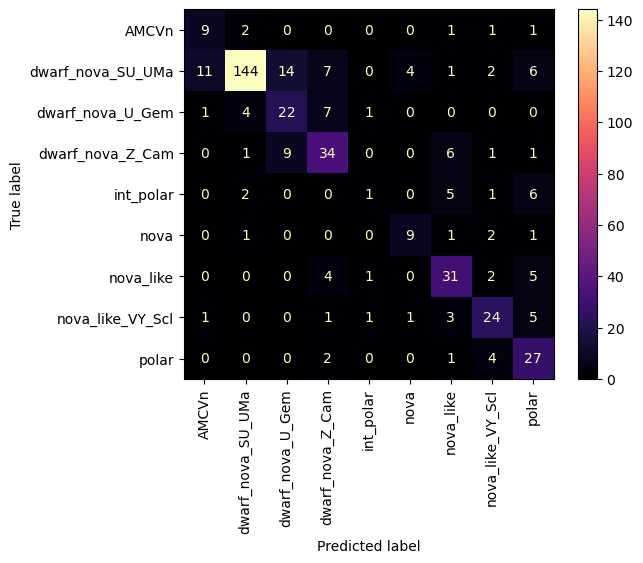

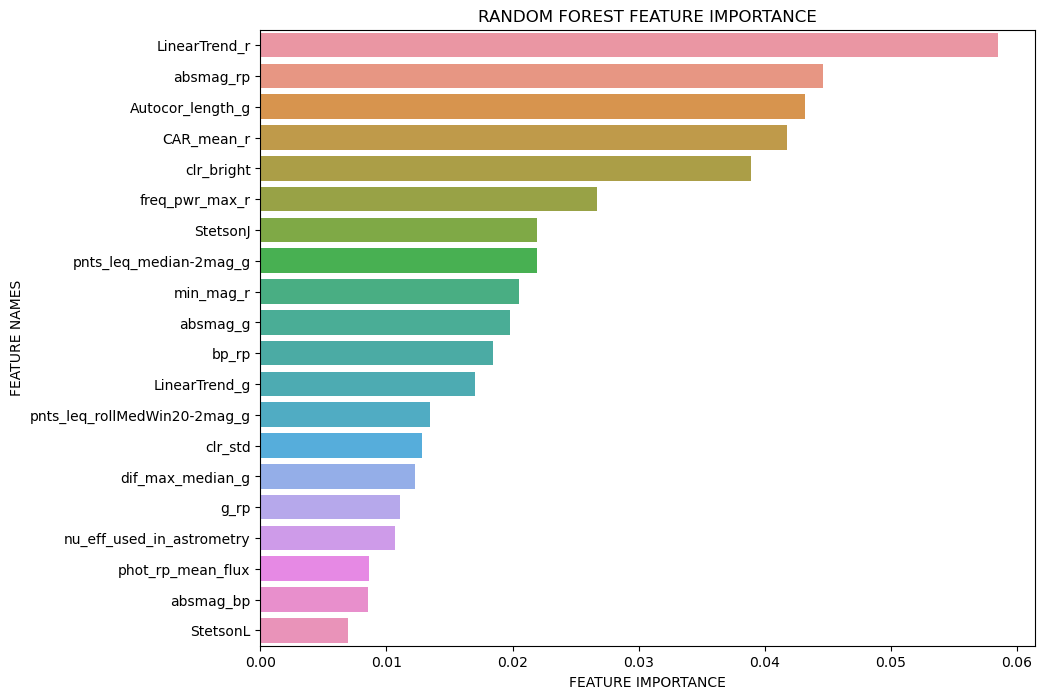

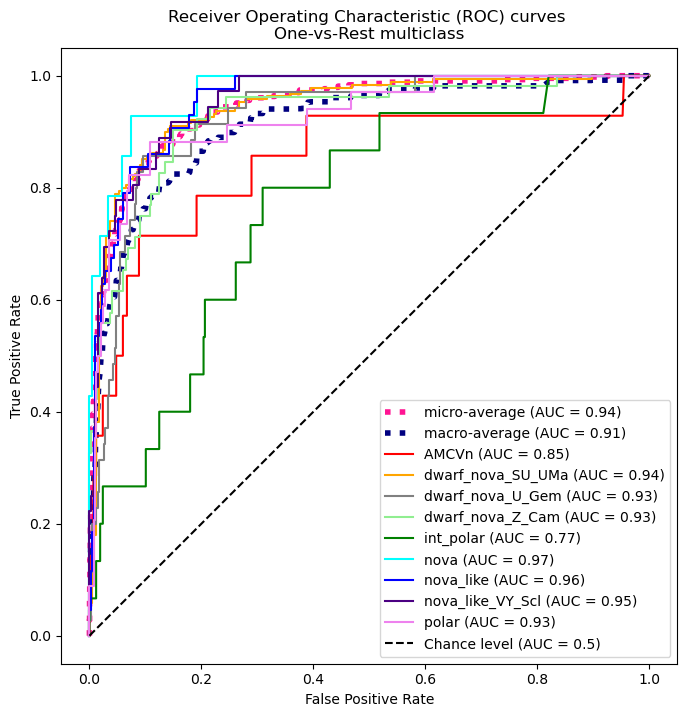

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

# # Store best parameters and best model in variables.
# best_params = grid.best_params_
# best_model = grid.best_estimator_
# print(best_params)


# Collect unique class labels in order of y_test.
class_labels = enc.inverse_transform(np.unique(y_test))


# Make predictions and gather probabilities for applying model to test set.
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(xticks_rotation='vertical', cmap='magma')
disp.figure_.savefig(f'../results/test_cm.pdf', format='pdf', bbox_inches='tight')



# Plot roc one vs rest curves
# plot_roc(y_train, y_test, y_prob, enc, path=f'class_balance/roc_{refit}_{classifierNm}_{label_scheme}.pdf')


# Print and save the classification report
cr = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True, zero_division=0)
cr_df = pd.DataFrame(cr).transpose().round({'precision':2, 'recall':2, 'f1-score':2}).astype({'support':'int64'})
print(cr_df)


feature_importance_scores = best_model.named_steps['clf'].feature_importances_
plot_feature_importance(importance=feature_importance_scores, 
                        names=X_cols, model_type='RANDOM FOREST', top_n=20, path=f'../results/test_feature_importance.pdf')

plot_roc(y_train, y_test, y_prob, enc, path=f'../results/test_roc_curve.pdf')

In [7]:
# save the model and class labels using pickle
import pickle
pickle.dump(best_model, open(f'../results/test_rfmodel.pkl', 'wb'))
pickle.dump(enc, open(f'../results/test_encoder.pkl', 'wb'))